In [47]:
import pandas as pd
import numpy as np
import os
import json
import statistics
import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from dateutil import parser
import datetime
import matplotlib.pyplot as plt
from dateutil.tz import tzutc
import math

In [48]:
d = "./analysis/result_long"

dirs_to_analyze = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o)) and "\\experiment" in os.path.join(d, o)]


In [49]:
rowsList = []
numjobs = []
batches = []

for curdir in dirs_to_analyze:
    row = {}    
    try:
        time_summary = json.load(open(curdir + "/summary.json"))
        service_times = []
        process_times = []
        wait_times = []
        
        start_time = parser.parse(time_summary["start"])
        end_time = parser.parse(time_summary["shutdown"])

        time_offset = datetime.timedelta(minutes=30)
        batch_start_time = start_time + time_offset

        batch_start_seconds = (batch_start_time-datetime.datetime(1970,1,1).replace(tzinfo=tzutc())).total_seconds()
        end_seconds = (end_time.replace(tzinfo=None)-datetime.datetime(1970,1,1)).total_seconds()

        num_batches = 4

        batch_delta = (end_seconds - batch_start_seconds) / float(num_batches)


        batch_num = 0
        batch_jobs = []

        for batch_start in np.arange(batch_start_seconds, end_seconds, batch_delta):
            batch_num = batch_num + 1
#             print("Batch ", batch_num)
#             print(batch_start, " - ", batch_start + batch_delta)
            new_batch_jobs = []

            i = -1
            for job in time_summary['jobs']:
                i = i + 1
                if (float(job['end']) >= batch_start) & (float(job['end']) < batch_start + batch_delta):
                    new_batch_jobs.append(i)

#             print("Num jobs", len(new_batch_jobs))
            numjobs.append(len(new_batch_jobs))
            batch_jobs.append(new_batch_jobs)
        
        batches.append(batch_jobs)
        
        row['Num generated'] = time_summary['jobCount']

        for job in time_summary['jobs']:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)

        row['Service Time mean'] = statistics.mean(service_times)
        row['Service Time std'] = statistics.stdev(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Process Time std'] = statistics.stdev(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Waiting Time std'] = statistics.stdev(wait_times)
    except Exception as e:
        print("Error parsing time summary for folder " + curdir)
        print(e)
        
    try:
        config = json.load(open(curdir + "/config.json"))
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])

    except Exception as e:
        print("Error parsing config for folder " + curdir)
        print(e)
        
    try:
        accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
        row['Num finished'] = accuracy["top1"].count()
        row['Top 1 mean'] = accuracy["top1"].mean()
        row['Top 1 std'] = accuracy["top1"].std()
        row['Top 5 mean'] = accuracy["top5"].mean()
        row['Top 5 std'] = accuracy["top5"].std()
        row['loss mean'] = accuracy["loss"].mean()
        row['loss std'] = accuracy["loss"].std()
        row['lossnum'] = accuracy["lossnum"].mean()
    except Exception as e:
        print("Error parsing accuracy for folder " + curdir)
        print(e)
        
    
    rowsList.append(row) 
    
analysis_old = pd.DataFrame(rowsList)
# analysis_old

In [50]:
# mu = analysis["Top 1 mean"].mean()
# sigma = analysis["Top 1 mean"].std()
mu = 0.9
sigma = 0.05
def z_score(x, mu, sig):
    return (x-mu)/sig

In [146]:
## Creating batches
rowsList = []
numjobs = []

new_df = pd.DataFrame(columns=analysis_old.columns)
i = -1
for curdir in dirs_to_analyze:
#     print(curdir)
    i = i + 1
    time_summary = json.load(open(curdir + "/summary.json"))
    config = json.load(open(curdir + "/config.json"))
    accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
    accuracy["Experiment"] = [int(x.split(".")[0]) for x in accuracy.index]

    experiment_batches = batches[i]
    batch_num = 0
    for curbat in experiment_batches:
        batch_num = batch_num + 1
        if len(curbat) == 0:
            continue
        row = {}
        
        service_times = []
        process_times = []
        wait_times = []
        batch_summary = time_summary['jobs'][min(curbat):max(curbat)+1]
        for job in batch_summary:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)
        row['Batch Number'] = batch_num
        row['Experiment Number'] = i
        row['Service Time mean'] = statistics.mean(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])
        
        
        row['Experiment Name'] = str(row['Batch Size']) + " - " + str(row['Max Epochs']) + " - " + str(row['Learning Rate'])
        
        batch_accuracy = accuracy[accuracy["Experiment"].isin(curbat)]
        row['Num finished'] = batch_accuracy["top1"].count()
        row['Top 1 mean'] = batch_accuracy["top1"].mean()
        row['Top 1 std'] = batch_accuracy["top1"].std()
        row['Top 5 mean'] = batch_accuracy["top5"].mean()
        row['Top 5 std'] = batch_accuracy["top5"].std()
        row['loss mean'] = batch_accuracy["loss"].mean()
        row['loss std'] = batch_accuracy["loss"].std()
        row['lossnum'] = batch_accuracy["lossnum"].mean()
        row['Zscore1_static'] = z_score(row['Top 1 mean'], mu ,sigma)
        row['Zscore5_static'] = z_score(row['Top 5 mean'], mu, sigma)
        row['Zscore1_static'] = z_score(row['Top 1 mean'], mu ,sigma)
        row['Zscore5_static'] = z_score(row['Top 5 mean'], mu, sigma)
        row['EZscore1_static'] = math.e**row['Zscore1_static'] /  row['Service Time mean']
        row['EZscore5_static'] = math.e**row['Zscore5_static'] / row['Service Time mean']
        
        rowsList.append(row) 

muTop1 = np.mean([x["Top 1 mean"] for x in rowsList])
muTop5 = np.mean([x["Top 5 mean"] for x in rowsList])
sigmaTop1 = np.std([x["Top 1 mean"] for x in rowsList])
sigmaTop5 = np.std([x["Top 5 mean"] for x in rowsList])

for row in rowsList:
        row['Zscore1'] = z_score(row['Top 1 mean'], muTop1 ,sigmaTop1)
        row['Zscore5'] = z_score(row['Top 5 mean'], muTop5, sigmaTop5)
        row['EZscore1'] = math.e**row['Zscore1'] /  row['Service Time mean']
        row['EZscore5'] = math.e**row['Zscore5'] / row['Service Time mean']
    
analysis_batch = pd.DataFrame(rowsList)
analysis_batch

,Batch Number,Batch Size,EZscore1,EZscore1_static,EZscore5,EZscore5_static,Executor Memory,Experiment Name,Experiment Number,Lambda,...,Top 5 mean,Top 5 std,Waiting Time mean,Zscore1,Zscore1_static,Zscore5,Zscore5_static,loss mean,loss std,lossnum
0,1,128,0.000940,0.002524,0.001060,0.012881,1,128 - 10 - 0.005,0,0.001,...,0.995400,0.000283,0.000074,-0.709635,0.278000,-0.589805,1.908000,0.320982,0.010210,157.0
1,2,128,0.001059,0.002739,0.001520,0.013225,1,128 - 10 - 0.005,0,0.001,...,0.996533,0.000473,0.000083,-0.594575,0.356000,-0.233057,1.930667,0.306239,0.004603,157.0
2,3,128,0.000671,0.001759,0.000767,0.008590,1,128 - 10 - 0.005,0,0.001,...,0.995680,0.000517,259.181745,-0.636469,0.327600,-0.501663,1.913600,0.314583,0.016267,157.0
3,4,128,0.000399,0.001017,0.000487,0.004721,1,128 - 10 - 0.005,0,0.001,...,0.996167,0.000712,904.541502,-0.546880,0.388333,-0.348474,1.923333,0.305998,0.015216,157.0
4,1,128,0.000532,0.001149,0.000674,0.003900,1,128 - 20 - 0.005,1,0.001,...,0.997920,0.000356,897.376438,-0.033437,0.736400,0.203428,1.958400,0.221667,0.008146,157.0
5,2,128,0.000506,0.001083,0.000635,0.003611,1,128 - 20 - 0.005,1,0.001,...,0.997975,0.000299,1005.769354,-0.006000,0.755000,0.220743,1.959500,0.220593,0.004009,157.0
6,3,128,0.000315,0.000674,0.000402,0.002253,1,128 - 20 - 0.005,1,0.001,...,0.998025,0.000479,2178.482663,-0.007475,0.754000,0.236475,1.960500,0.220834,0.018029,157.0
7,4,128,0.000627,0.001330,0.000795,0.004359,1,128 - 20 - 0.005,1,0.001,...,0.998100,0.000283,594.590872,0.023503,0.775000,0.260087,1.962000,0.218843,0.011489,157.0
8,1,128,0.000715,0.002376,0.000581,0.017818,1,128 - 5 - 0.005,2,0.001,...,0.992260,0.000336,61.443957,-1.369902,-0.169600,-1.578189,1.845200,0.447040,0.009694,157.0
9,2,128,0.000644,0.002214,0.000753,0.018120,1,128 - 5 - 0.005,2,0.001,...,0.993083,0.000694,52.817880,-1.474734,-0.240666,-1.319022,1.861667,0.458039,0.019726,157.0


In [168]:
muTop1



0.9379533629666473

C:\Python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


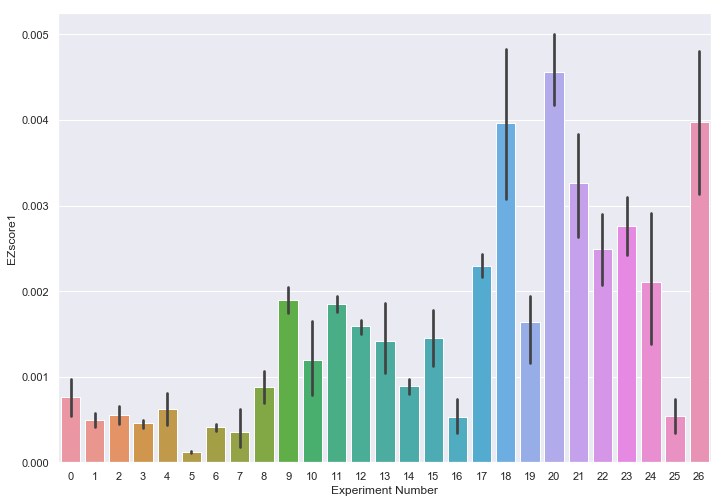

In [169]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x="Experiment Number", y="EZscore1", data=analysis_batch, ci=90)

(0.8, 1.0)

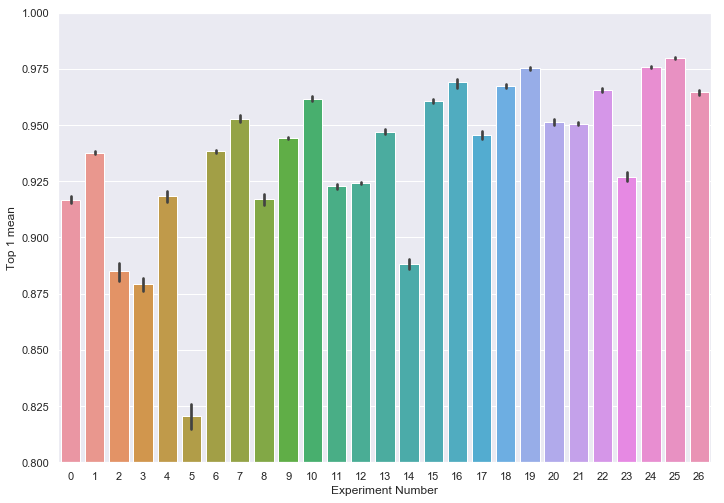

In [148]:
bp = sns.barplot(x="Experiment Number", y="Top 1 mean", data=analysis_batch, ci=90)
axes = bp.axes
axes.set_ylim(0.8,1.0)

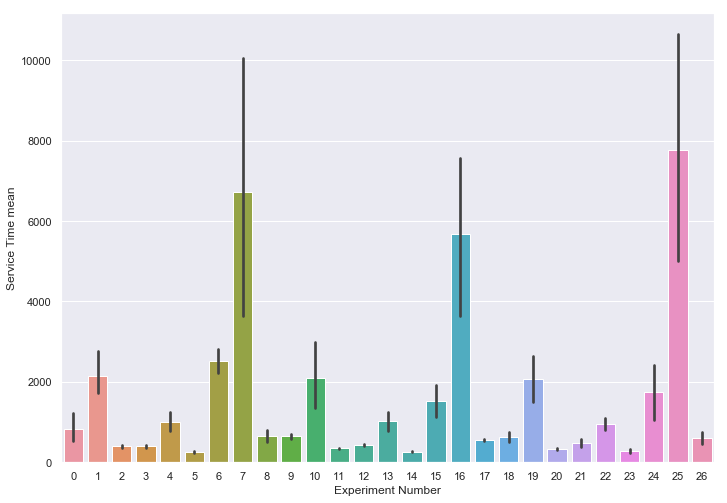

In [149]:
sns.barplot(x="Experiment Number", y="Service Time mean", data=analysis_batch, ci=90)


In [150]:
print("Chosen experiments")

best_number = analysis_batch.groupby("Experiment Number")["EZscore1"].mean().sort_values(ascending=False).index[0]
fast_number = analysis_batch.groupby("Experiment Number")["Service Time mean"].mean().sort_values().index[0]
accuracy_number = analysis_batch.groupby("Experiment Number")["Top 1 mean"].mean().sort_values(ascending=False).index[0]
final_experiments = [best_number, fast_number, accuracy_number]
df_final  = analysis_batch[analysis_batch["Experiment Number"].isin(final_experiments)][["Experiment Number", "Batch Size", "Max Epochs", "Learning Rate", "Lambda"]].drop_duplicates()
df_final

Chosen experiments


,Experiment Number,Batch Size,Max Epochs,Learning Rate,Lambda
20,5,256,5,0.005,0.001
78,20,128,5,0.020,0.001
96,25,64,20,0.020,0.001


In [151]:
## For bash commands:

cols = ["learningRate", "batchSize", "maxEpoch", "numberOfNodes", "lambda"]
nodes = [2, 4]
output_df = df_final.append([df_final]*(len(nodes)-1), ignore_index=True)
output_df = output_df.drop(columns=["Experiment Number"])
output_df["Nodes"] = np.sort(nodes*3)
output_df = output_df.rename(columns={'Batch Size':cols[1], 'Max Epochs':cols[2], 'Learning Rate':cols[0], 'Nodes':cols[3], "Lambda": cols[4]})
output_df

,batchSize,maxEpoch,learningRate,lambda,numberOfNodes
0,256,5,0.005,0.001,2
1,128,5,0.020,0.001,2
2,64,20,0.020,0.001,2
3,256,5,0.005,0.001,4
4,128,5,0.020,0.001,4
5,64,20,0.020,0.001,4


In [152]:
print(output_df.to_dict())

{'batchSize': {0: 256, 1: 128, 2: 64, 3: 256, 4: 128, 5: 64}, 'maxEpoch': {0: 5, 1: 5, 2: 20, 3: 5, 4: 5, 5: 20}, 'learningRate': {0: 0.005, 1: 0.02, 2: 0.02, 3: 0.005, 4: 0.02, 5: 0.02}, 'lambda': {0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001}, 'numberOfNodes': {0: 2, 1: 2, 2: 2, 3: 4, 4: 4, 5: 4}}


In [153]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Top 1 mean", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Top 1 mean": "Acc", "Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('Acc ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 26, 77) =  609.957, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Acc   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     610.0
Date:                Sat, 26 Oct 2019   Prob (F-statistic):           9.05e-79
Time:                        17:12:49   Log-Likelihood:                 481.71
No. Observations:                 104   AIC:                            -909.4
Df Residuals:                      77   BIC:                            -838.0
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.9169      0.001    669.726      0.000       0.914       0.920
C(BS)[T.128]                              -0.0317      0.002    -16.385      0.000      -0.036      -0.028
C(BS)[T.256]                              -0.0964      0.002    -46.086      0.000      -0.101      -0.092
C(ME)[T.10]                                0.0214      0.002     11.045      0.000       0.018       0.025
C(ME)[T.20]                                0.0358      0.002     18.484      0.000       0.032       0.040
C(LR)[T.0.01]                              0.0287      0.002     14.826      0.000       0.025       0.033
C(LR)[T.0.02]                              0.0478      0.002     24.705      0.000       0.044       0.052
C(BS)[T.128]:C(ME)[T.10]                   0.0103      0.003      3.755      0.000       0.005       0.016
C(BS)[T.256]:C(ME)[T.10]                   0.0373      0.003     13.088      0.000       0.032       0.043
C(BS)[T.128]:C(ME)[T.20]                   0.0168      0.003      6.120      0.000       0.011       0.022
C(BS)[T.256]:C(ME)[T.20]                   0.0619      0.003     21.720      0.000       0.056       0.068
C(BS)[T.128]:C(LR)[T.0.01]                 0.0089      0.003      3.238      0.002       0.003       0.014
C(BS)[T.256]:C(LR)[T.0.01]                 0.0390      0.003     13.182      0.000       0.033       0.045
C(BS)[T.128]:C(LR)[T.0.02]                 0.0184      0.003      6.709      0.000       0.013       0.024
C(BS)[T.256]:C(LR)[T.0.02]                 0.0586      0.003     19.828      0.000       0.053       0.065
C(ME)[T.10]:C(LR)[T.0.01]                 -0.0062      0.003     -2.271      0.026      -0.012      -0.001
C(ME)[T.20]:C(LR)[T.0.01]                 -0.0124      0.003     -4.532      0.000      -0.018      -0.007
C(ME)[T.10]:C(LR)[T.0.02]                 -0.0103      0.003     -3.749      0.000      -0.016      -0.005
C(ME)[T.20]:C(LR)[T.0.02]                 -0.0208      0.003     -7.601      0.000      -0.026      -0.015
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.01]    -0.0040      0.004     -1.030      0.306      -0.012       0.004
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.01]    -0.0165      0.004     -4.100      0.000      -0.025      -0.008
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.01]    -0.0011      0.004     -0.290      0.773      -0.009       0.007
C(BS)[T.256]:C(ME)[T.20]:C(LR)[T.0.01]    -0.0265      0.004     -6.573      0.000      -0.035      -0.018
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.02]    -0.0055      0.004     -1.416      0.161      -0.013       0.002
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.02]    -0.0248      0.004     -6.154      0.000      -0.033      -0.017
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.02]    -0.0079      0.004     -2.051      0.044     

,sum_sq,df,F,PR(>F),Var
C(BS),0.030007,2.0,2001.051009,4.199108e-67,24.46%
C(ME),0.029644,2.0,1976.798820,6.655325e-67,24.17%
C(LR),0.049642,2.0,3310.408013,2.145182e-75,40.47%
C(BS):C(ME),0.004577,4.0,152.611336,8.762208e-36,3.73%
C(BS):C(LR),0.003975,4.0,132.538809,1.028364e-33,3.24%
C(ME):C(LR),0.003433,4.0,114.459204,1.331388e-31,2.80%
C(BS):C(ME):C(LR),0.000808,8.0,13.478668,5.306369e-12,0.66%
Residual,0.000577,77.0,NaN,NaN,0.47%


In [154]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["EZscore1", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('EZscore1 ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 26, 77) =  21.929, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EZscore1   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     21.93
Date:                Sat, 26 Oct 2019   Prob (F-statistic):           8.06e-26
Time:                        17:12:49   Log-Likelihood:                 654.50
No. Observations:                 104   AIC:                            -1255.
Df Residuals:                      77   BIC:                            -1184.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.0009      0.000      3.404      0.001       0.000       0.001
C(BS)[T.128]                              -0.0003      0.000     -0.902      0.370      -0.001       0.000
C(BS)[T.256]                              -0.0008      0.000     -1.922      0.058      -0.002    2.75e-05
C(ME)[T.10]                               -0.0005      0.000     -1.297      0.198      -0.001       0.000
C(ME)[T.20]                               -0.0005      0.000     -1.442      0.153      -0.001       0.000
C(LR)[T.0.01]                              0.0014      0.000      3.844      0.000       0.001       0.002
C(LR)[T.0.02]                              0.0031      0.000      8.407      0.000       0.002       0.004
C(BS)[T.128]:C(ME)[T.10]                   0.0007      0.001      1.328      0.188      -0.000       0.002
C(BS)[T.256]:C(ME)[T.10]                   0.0008      0.001      1.495      0.139      -0.000       0.002
C(BS)[T.128]:C(ME)[T.20]                   0.0005      0.001      0.907      0.367      -0.001       0.002
C(BS)[T.256]:C(ME)[T.20]                   0.0010      0.001      1.903      0.061   -4.75e-05       0.002
C(BS)[T.128]:C(LR)[T.0.01]                -0.0001      0.001     -0.220      0.826      -0.001       0.001
C(BS)[T.256]:C(LR)[T.0.01]                -0.0006      0.001     -1.155      0.252      -0.002       0.000
C(BS)[T.128]:C(LR)[T.0.02]                 0.0009      0.001      1.767      0.081      -0.000       0.002
C(BS)[T.256]:C(LR)[T.0.02]                -0.0005      0.001     -0.803      0.425      -0.002       0.001
C(ME)[T.10]:C(LR)[T.0.01]                 -0.0004      0.001     -0.709      0.481      -0.001       0.001
C(ME)[T.20]:C(LR)[T.0.01]                 -0.0012      0.001     -2.383      0.020      -0.002      -0.000
C(ME)[T.10]:C(LR)[T.0.02]                 -0.0014      0.001     -2.675      0.009      -0.002      -0.000
C(ME)[T.20]:C(LR)[T.0.02]                 -0.0029      0.001     -5.592      0.000      -0.004      -0.002
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.01]     0.0002      0.001      0.269      0.789      -0.001       0.002
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.01]     0.0007      0.001      0.964      0.338      -0.001       0.002
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.01]     0.0006      0.001      0.866      0.389      -0.001       0.002
C(BS)[T.256]:C(ME)[T.20]:C(LR)[T.0.01]     0.0013      0.001      1.658      0.101      -0.000       0.003
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.02]     0.0006      0.001      0.780      0.438      -0.001       0.002
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.02]     0.0016      0.001      2.036      0.045    3.42e-05       0.003
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.02]  4.357e-05      0.001      0.059      0.953     

,sum_sq,df,F,PR(>F),Var
C(BS),0.000004,2.0,8.217000,5.827104e-04,2.56%
C(ME),0.000019,2.0,35.614419,1.119396e-11,11.07%
C(LR),0.000091,2.0,168.547929,7.438901e-29,52.41%
C(BS):C(ME),0.000014,4.0,13.049862,3.675217e-08,8.12%
C(BS):C(LR),0.000005,4.0,4.419405,2.867965e-03,2.75%
C(ME):C(LR),0.000016,4.0,14.955478,4.356403e-09,9.30%
C(BS):C(ME):C(LR),0.000003,8.0,1.466044,1.835632e-01,1.82%
Residual,0.000021,77.0,NaN,NaN,11.97%


In [155]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Process Time mean", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Process Time mean" : "PT","Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('PT ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 26, 77) =  681.094, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PT   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     681.1
Date:                Sat, 26 Oct 2019   Prob (F-statistic):           1.33e-80
Time:                        17:12:49   Log-Likelihood:                -486.80
No. Observations:                 104   AIC:                             1028.
Df Residuals:                      77   BIC:                             1099.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                475.7682     15.165     31.372      0.000     445.571     505.966
C(BS)[T.128]                            -173.7309     21.447     -8.101      0.000    -216.437    -131.025
C(BS)[T.256]                            -248.2050     23.165    -10.715      0.000    -294.333    -202.077
C(ME)[T.10]                              355.0837     21.447     16.557      0.000     312.378     397.790
C(ME)[T.20]                             1131.4608     21.447     52.757      0.000    1088.755    1174.167
C(LR)[T.0.01]                              9.0437     21.447      0.422      0.674     -33.662      51.750
C(LR)[T.0.02]                            -12.8867     21.447     -0.601      0.550     -55.593      29.819
C(BS)[T.128]:C(ME)[T.10]                -127.2682     30.330     -4.196      0.000    -187.664     -66.873
C(BS)[T.256]:C(ME)[T.10]                -214.4607     31.569     -6.793      0.000    -277.322    -151.599
C(BS)[T.128]:C(ME)[T.20]                -460.6970     30.330    -15.189      0.000    -521.092    -400.302
C(BS)[T.256]:C(ME)[T.20]                -699.8948     31.569    -22.170      0.000    -762.756    -637.033
C(BS)[T.128]:C(LR)[T.0.01]                -5.0552     30.330     -0.167      0.868     -65.451      55.340
C(BS)[T.256]:C(LR)[T.0.01]               -12.2243     32.760     -0.373      0.710     -77.459      53.010
C(BS)[T.128]:C(LR)[T.0.02]                 8.1133     30.330      0.267      0.790     -52.282      68.509
C(BS)[T.256]:C(LR)[T.0.02]                -0.4231     32.760     -0.013      0.990     -65.658      64.811
C(ME)[T.10]:C(LR)[T.0.01]                  6.4772     30.330      0.214      0.831     -53.918      66.873
C(ME)[T.20]:C(LR)[T.0.01]                -33.5131     30.330     -1.105      0.273     -93.908      26.882
C(ME)[T.10]:C(LR)[T.0.02]                -31.7302     30.330     -1.046      0.299     -92.126      28.665
C(ME)[T.20]:C(LR)[T.0.02]                -70.7597     30.330     -2.333      0.022    -131.155     -10.364
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.01]    10.8904     42.894      0.254      0.800     -74.522      96.302
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.01]     9.7222     44.645      0.218      0.828     -79.177      98.622
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.01]    22.8803     42.894      0.533      0.595     -62.532     108.292
C(BS)[T.256]:C(ME)[T.20]:C(LR)[T.0.01]    30.7793     44.645      0.689      0.493     -58.120     119.679
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.02]    25.2467     42.894      0.589      0.558     -60.165     110.659
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.02]    24.7399     44.645      0.554      0.581     -64.160     113.639
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.02]    43.5402     42.894      1.015      0.313     

,sum_sq,df,F,PR(>F),Var
C(BS),5.356690e+06,2.0,2911.471505,2.833035e-73,32.18%
C(ME),9.809989e+06,2.0,5331.931061,2.721986e-83,58.94%
C(LR),1.946284e+04,2.0,10.578457,8.728477e-05,0.12%
C(BS):C(ME),1.374395e+06,4.0,373.505925,1.419697e-49,8.26%
C(BS):C(LR),4.208047e+03,4.0,1.143580,3.424690e-01,0.03%
C(ME):C(LR),5.993984e+03,4.0,1.628927,1.755005e-01,0.04%
C(BS):C(ME):C(LR),1.994102e+03,8.0,0.270959,9.735154e-01,0.01%
Residual,7.083448e+04,77.0,NaN,NaN,0.43%


In [156]:
# Process time results:
print("Max avg process time: ", analysis["Process Time mean"].max())
print("Min avg process time: ", analysis["Process Time mean"].min())
print("Mean avg process time: ", analysis["Process Time mean"].mean())

print("Min mu: ", "%.7f" % (1/analysis["Process Time mean"].max()))
print("Max mu: ", "%.7f" % (1/analysis["Process Time mean"].min()))
print("Mean mu: ", "%.7f" % (1/analysis["Process Time mean"].mean()))


NameError: name 'analysis' is not defined

In [0]:
important_cols=[x for x in analysis.columns if "Top 1" in x]
important_cols.extend([x for x in analysis.columns if "Time" in x])


In [0]:
display(rp.summary_cont(analysis[[x for x in important_cols if "Process Time mean" in x]].groupby(analysis["Batch Size"])))

In [0]:
analysis.sort_values(by=['Top 1 mean'], ascending=False)

In [0]:
analysis.sort_values(by=['Top 1 mean'], ascending=False)

In [0]:
## Service time / accuracy^(something) (adapted IES)
alpha = 2
analysis["Acc/Service"] = analysis['Service Time mean']/(analysis['Top 1 mean']**alpha)
display(analysis.sort_values(by=['Acc/Service']).head())
display(analysis.sort_values(by=['Acc/Service']).tail())

In [0]:
## Service time / accuracy^(something) (adapted IES)
alpha = 2
analysis["Acc/Service"] = analysis['Service Time mean']/(analysis['Top 1 mean']**alpha)
display(analysis.sort_values(by=['Acc/Service']).head())
display(analysis.sort_values(by=['Acc/Service']).tail())

In [0]:
## LISAS score, lower is better

analysis["LISAS"] = analysis['Service Time mean'] + analysis["Service Time std"] / analysis["Top 1 std"] * (1-analysis["Top 1 mean"])
display(analysis.sort_values(by=['LISAS']).head())
display(analysis.sort_values(by=['LISAS']).tail())


In [0]:
## Adapted RCS
c = analysis["Num finished"] * analysis["Top 1 mean"]
sumRT = analysis["Num finished"] * analysis["Service Time mean"]
analysis["RCS"] = c / sumRT
display(analysis.sort_values(by=['RCS'], ascending=False).head())
display(analysis.sort_values(by=['RCS'], ascending=False).tail())